In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 生成模拟数据

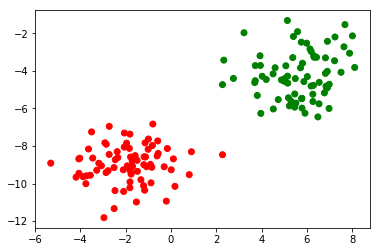

In [2]:
# 导入sklearn模拟二分类数据生成模块
from sklearn.datasets.samples_generator import make_blobs
# 生成模拟二分类数据集
X, y =  make_blobs(n_samples=150, n_features=2, centers=2, cluster_std=1.2, random_state=40)
# 设置颜色参数
colors = {0:'r', 1:'g'}
# 绘制二分类数据集的散点图
plt.scatter(X[:,0], X[:,1], marker='o', c=pd.Series(y).map(colors))
plt.show();

In [3]:
# 将标签转换为1/-1
y_ = y.copy()
y_[y_==0] = -1
y_ = y_.astype(float)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, random_state=43)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(105, 2) (105,) (45, 2) (45,)


### cvxopt用法

In [5]:
from cvxopt import matrix, solvers

In [6]:
# 定义二次规划参数
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])

# 构建求解
sol = solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  6e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  2e-16  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  2e-16  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  6e-17  3e-16
 6:  2.0062e+01  1.9974e+01  9e-02  9e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  1e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  3e-16
Optimal solution found.


In [7]:
# 获取最优值
print(sol['x'], sol['primal objective'])

[ 7.13e-07]
[ 5.00e+00]
 20.00000617311241


### 线性可分支持向量机

In [8]:
### 实现线性可分支持向量机
### 硬间隔最大化策略
class Hard_Margin_SVM:
    ### 线性可分支持向量机拟合方法
    def fit(self, X, y):
        # 训练样本数和特征数
        m, n = X.shape

        # 初始化二次规划相关变量：P/q/G/h
        self.P = matrix(np.identity(n + 1, dtype=np.float))
        self.q = matrix(np.zeros((n + 1,), dtype=np.float))
        self.G = matrix(np.zeros((m, n + 1), dtype=np.float))
        self.h = -matrix(np.ones((m,), dtype=np.float))

        # 将数据转为变量
        self.P[0, 0] = 0
        for i in range(m):
            self.G[i, 0] = -y[i]
            self.G[i, 1:] = -X[i, :] * y[i]
        
        # 构建二次规划求解
        sol = solvers.qp(self.P, self.q, self.G, self.h)

        # 对权重和偏置寻优
        self.w = np.zeros(n,) 
        self.b = sol['x'][0] 
        for i in range(1, n + 1):
            self.w[i - 1] = sol['x'][i]
        return self.w, self.b

    ### 定义模型预测函数
    def predict(self, X):
        return np.sign(np.dot(self.w, X.T) + self.b)

In [9]:
# 创建线性可分支持向量机模型实例
hard_margin_svm = Hard_Margin_SVM()
# 执行训练
hard_margin_svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  2.1061e-02  2.0725e+01  3e+02  2e+00  8e+02
 1:  1.7678e-01 -4.0311e+01  5e+01  3e-01  1e+02
 2:  2.5467e-01 -1.3854e+00  2e+00  1e-02  4e+00
 3:  2.1218e-01  4.0205e-02  2e-01  6e-04  2e-01
 4:  1.8309e-01  1.5738e-01  3e-02  8e-05  4e-02
 5:  1.8241e-01  1.8207e-01  3e-04  1e-06  4e-04
 6:  1.8239e-01  1.8239e-01  3e-06  1e-08  4e-06
 7:  1.8239e-01  1.8239e-01  3e-08  1e-10  4e-08
Optimal solution found.


(array([0.40882768, 0.44457681]), 1.8310613288769853)

In [10]:
# 模型预测
y_pred = hard_margin_svm.predict(X_test)
from sklearn.metrics import accuracy_score
# 计算测试集准确率
print(accuracy_score(y_test, y_pred))

1.0


In [11]:
from matplotlib.colors import ListedColormap

### 绘制线性可分支持向量机决策边界图
def plot_classifer(model, X, y):
    # 超参数边界
    x_min = -7
    x_max = 12
    y_min = -12
    y_max = -1
    step = 0.05
    # meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    # 模型预测
    z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # 定义color map
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#003300'])
    z = z.reshape(xx.shape)

    plt.figure(figsize=(8, 5), dpi=96)
    plt.pcolormesh(xx, yy, z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.show()

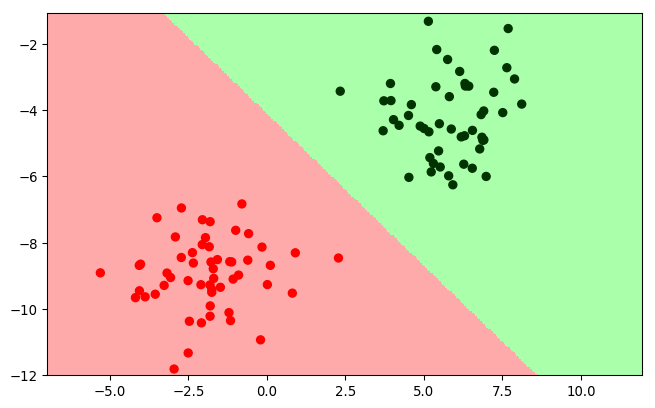

In [12]:
plot_classifer(hard_margin_svm, X_train, y_train)

In [13]:
# 导入sklearn线性SVM分类模块
from sklearn.svm import LinearSVC
# 创建模型实例
clf = LinearSVC(random_state=0, tol=1e-5)
# 训练
clf.fit(X_train, y_train)
# 预测
y_pred = clf.predict(X_test)
# 计算测试集准确率
print(accuracy_score(y_test, y_pred))

1.0
